# Import necessary libraries

In [1]:
import os

In [2]:
# move working dir up to parent, allows us to import from utils without too many shenanigans
os.chdir(os.pardir)

In [3]:
import copy
import datetime
import pickle
from math import log2, pow, sqrt
from multiprocessing import Pool

import networkx as nx
import pandas as pd
from matplotlib import colormaps as cmap
from matplotlib.pyplot import figure
from tqdm import tqdm

from utils.data_generated import (load_is_in_movies, load_movie_metadata, load_people)


# Functions used for generating, clustering, displaying, saving, and loading graphs

In [4]:
# This code block contains the functions necessary to generate a graph

# Helper function that combines all the movies a person has worked on
def combine_movies(id, period, isinmovies):
    distinct_movies = set()
    entry = isinmovies[isinmovies.index == id]
    entry = entry[entry.columns[~entry.isnull().all()]]
    for job in entry:
        movies_set = set()
        movies = entry[job].values[0]
        for movie in movies:
            if movie in period:
                movies_set.add(movie)
        if len(movies_set) > 0:
            distinct_movies = distinct_movies.union(movies_set)
    return distinct_movies

# Creates an empty graph
def initialize_graph():
    print('Initializing Graph!')
    return nx.Graph()

# Generates nodes for the graph and assigns them attributes
def compute_nodes(G, moviesinperiod, people, isinmovies):
    print('Computing Nodes!')
    period = moviesinperiod['title_id_imdb'].values

    with tqdm(total=len(people)) as progress_bar:
        for _, row in tqdm(people.iterrows()):
            id = row['person_name_id']
            name = row['person_name']
            movies = combine_movies(id, period, isinmovies)
                
            if len(movies) == 0:
                pass
            elif len(movies) >= TRESHOLD_COLOR:
                G.add_node(id, size=BASE_SIZE*len(movies), alpha=BASE_ALPHA, name=name, movies=movies, color='red')
            else:
                G.add_node(id, size=BASE_SIZE*len(movies), alpha=BASE_ALPHA, name=name, movies=movies, color='blue')
            progress_bar.update(1)

# For every pair of nodes computes the edge thickness and updates the alpha of the node color
def compute_edges(G):
    print("Computing Edges!")

    with tqdm(total=G.order()) as progress_bar:
        for node1 in tqdm(G.nodes(data='movies')):
            id1 = node1[0]
            movies1 = node1[1]

            for node2 in G.nodes(data='movies'):
                id2 = node2[0]            

                if not G.has_edge(id1, id2) and id1 != id2:
                    movies2 = node2[1]
                    common_movies = movies1.intersection(movies2)
                    
                    if len(common_movies) > 0:

                        G.add_edge(id1, id2, weight=len(common_movies) * MUL_WEIGHT)
                        G.nodes[id1]['alpha'] = pow(G.nodes[id1]['alpha'], pow(PARAMETER_WEIGHT, len(common_movies)))
                        G.nodes[id2]['alpha'] = pow(G.nodes[id2]['alpha'], pow(PARAMETER_WEIGHT, len(common_movies)))
            progress_bar.update(1)

#Performs all steps of graph generation
def generate_graph(moviesinperiod, people, isinmovies):
    G = initialize_graph()
    compute_nodes(G, moviesinperiod, people, isinmovies)
    compute_edges(G)
    return G


In [5]:
# This code block contains the functions necessary to cluster a graph

# Computes the clustering coefficient for nodes
def compute_clustering_coefficient(G):
    return nx.clustering(G)

# Generates a copy of the original graph with updated colors to indicate clusters
def generate_clustered_graph(G, clustering, colormap):
    G_clustered = copy.deepcopy(G)
    for node in G_clustered.nodes(data=True):
        node[1]['color'] = cmap[colormap](clustering[node[0]])
    return G_clustered

In [6]:
# This code block contains the functions necessary to display a graph

# Position nodes using Fruchterman-Reingold force-directed algorithm
def compute_node_positions(G):
    print('Computing Node Layout! (Warning: may take a long time)')
    return nx.spring_layout(G, k=SPRING_COEFFICIENT/sqrt(G.order()))

# Returns nodes for which the labels will be displayed
def compute_heavy_nodes(G):
    heavy_nodes = []
    for node in G.nodes(data=True):
        if node[1]['size'] >= TRESHOLD_LABEL:
            heavy_nodes.append(node)
    return heavy_nodes

# Computes all the parameters needed to draw the graph apart from the node positions and the graph itself
def compute_params(G):
    nodes = G.nodes()
    node_sizes = [x*log2(max(2,x)) for x in list(nx.get_node_attributes(G, 'size').values())]
    node_colors = list(nx.get_node_attributes(G, 'color').values())
    node_alphas = list(nx.get_node_attributes(G, 'alpha').values())

    edges = G.edges()
    edge_weights = list(nx.get_edge_attributes(G, 'weight').values())
    edge_colors = 'lightblue'
    edge_alphas = 0.5

    heavy_nodes = compute_heavy_nodes(G)
    subgraph = G.subgraph([node[0] for node in heavy_nodes])
    labels = {node[0]:node[1]['name'] for node in heavy_nodes}
    font_sizes = 9
    font_colors = 'black'
    font_alphas = 0.5
    vertical_alignment = 'bottom'

    return {'node_params':{'ids':nodes, 'sizes':node_sizes, 'colors':node_colors, 'alphas':node_alphas},
            'edge_params':{'ids':edges, 'weights':edge_weights, 'colors':edge_colors, 'alphas':edge_alphas},
            'label_params':{'subgraph':subgraph, 'labels':labels, 'sizes':font_sizes, 'colors':font_colors, 'alphas':font_alphas, 'vertical_alignments':vertical_alignment}}

# Initializes an empty figure and returns the handle
def init_graph(size):
    return figure(figsize=size)

# Draws nodes according to params
def draw_nodes(G, node_positions, params):
    nx.draw_networkx_nodes(G, node_positions,
                        nodelist=params['ids'],
                        node_size=params['sizes'],
                        node_color=params['colors'],
                        alpha=params['alphas'])

# Draws edges according to params
def draw_edges(G, node_positions, params):
    nx.draw_networkx_edges(G, node_positions,
                        edgelist=params['ids'],
                        width=params['weights'],
                        edge_color=params['colors'],
                        alpha=params['alphas'])

# Draws labels according to params
def draw_labels(node_positions, params):
    nx.draw_networkx_labels(params['subgraph'], node_positions,
                            labels=params['labels'],
                            font_size=params['sizes'],
                            font_color=params['colors'],
                            alpha=params['alphas'],
                            verticalalignment=params['vertical_alignments'])

# Draws the graph on a figure and returns the handle to the figure
def draw_graph(G, node_positions, size, params):
    fig = init_graph(size)
    draw_nodes(G, node_positions, params['node_params'])
    draw_edges(G, node_positions, params['edge_params'])
    draw_labels(node_positions, params['label_params'])

    return fig

In [7]:
# This code block contains the functions necessary to pickle/unpickle graphs and related objects
# that take a long time to compute. Also provides a function for saving figures.

# File directories
PATH_GRAPHS = '../generated/graphs/'
PATH_POSITIONS = '../generated/graphs/'
PATH_FIGURES = '../results/graphs/'
PATH_CLUSTER_FIGURE = '../results/graphs/'

# Filename suffixes
SUFFIX_GRAPHS = '_graph.pickle'
SUFFIX_POSITIONS = '_pos.pickle'
SUFFIX_FIGURES = '.png'
SUFFIX_CLUSTER_FIGURE = '_cluster.png'

def pickle_graph(G, filename):
    with open(PATH_GRAPHS + filename + SUFFIX_GRAPHS, 'wb') as handle:
        pickle.dump(G, handle, protocol=pickle.HIGHEST_PROTOCOL)

def pickle_positions(pos, filename):
    with open(PATH_POSITIONS + filename + SUFFIX_POSITIONS, 'wb') as handle:
        pickle.dump(pos, handle, protocol=pickle.HIGHEST_PROTOCOL)

def unpickle_graph(filename):
    with open(PATH_GRAPHS + filename + SUFFIX_GRAPHS, 'rb') as handle:
        return pickle.load(handle)

def unpickle_positions(filename):
    with open(PATH_POSITIONS + filename + SUFFIX_POSITIONS, 'rb') as handle:
        return pickle.load(handle)

def save_figure(fig, filename):
    fig.savefig(PATH_FIGURES + filename + SUFFIX_FIGURES)

def save_cluster_figure(fig, filename):
    fig.savefig(PATH_CLUSTER_FIGURE + filename + SUFFIX_CLUSTER_FIGURE)

# Parameter definitions and loading the datasets

In [8]:
# Decide the start date (inclusive) and start date (exclusive)
# that will be used to prune the dataframe
START_DATE = pd.to_datetime(datetime.date(2000,1,1))
END_DATE = pd.to_datetime(datetime.date(2000,2,1))

In [9]:
# Import the necessary dataframes for graph generation
# and prune the movies dataframe to include only the given time frame
movie_df = load_movie_metadata()
movie_df = movie_df.loc[(movie_df['release_date'] >= START_DATE) & (movie_df['release_date'] < END_DATE)]
people_df = load_people()
isinmovies_df = load_is_in_movies()


In [10]:
# Following are the constants used in graph generation/display
BASE_SIZE = 1               # Base size of a node (increases if a person is more active)
BASE_ALPHA = 0.01           # Base alpha of a node color (increases if a person has many connections)
MUL_WEIGHT = 0.3            # Base edge thickness (increases if two people work together often)
PARAMETER_WEIGHT = 0.9      # Parameter that controls how fast edge thickness increases for each connection (Smaller param => Faster convergence to 1)
TRESHOLD_LABEL = 3 #30      # Parameter that controls how active a person needs to be for their name to be displayed
TRESHOLD_COLOR = 2 #15      # Parameter that controls how active a person needs to be for their node color to change
SPRING_COEFFICIENT = 1.8    # Indicates how much the nodes should be forced to spread apart on the graph (default=1)

# Generating, clustering, displaying, saving, and loading the graph

In [11]:
# Common filename for graphs, positions and figures to be saved as
filename = 'test'

In [12]:
# Generate the graph
G = generate_graph(movie_df, people_df, isinmovies_df)
pickle_graph(G, filename)

Initializing Graph!
Computing Nodes!


74973it [09:23, 133.10it/s]3 [09:23<00:00, 139.58it/s]
100%|██████████| 74973/74973 [09:23<00:00, 133.10it/s]


Computing Edges!


100%|██████████| 2807/2807 [00:07<00:00, 386.06it/s]


In [13]:
# Compute node positions using Fruchterman-Reingold force-directed algorithm
node_positions = compute_node_positions(G)
pickle_positions(node_positions, filename)

Computing Node Layout! (Warning: may take a long time)


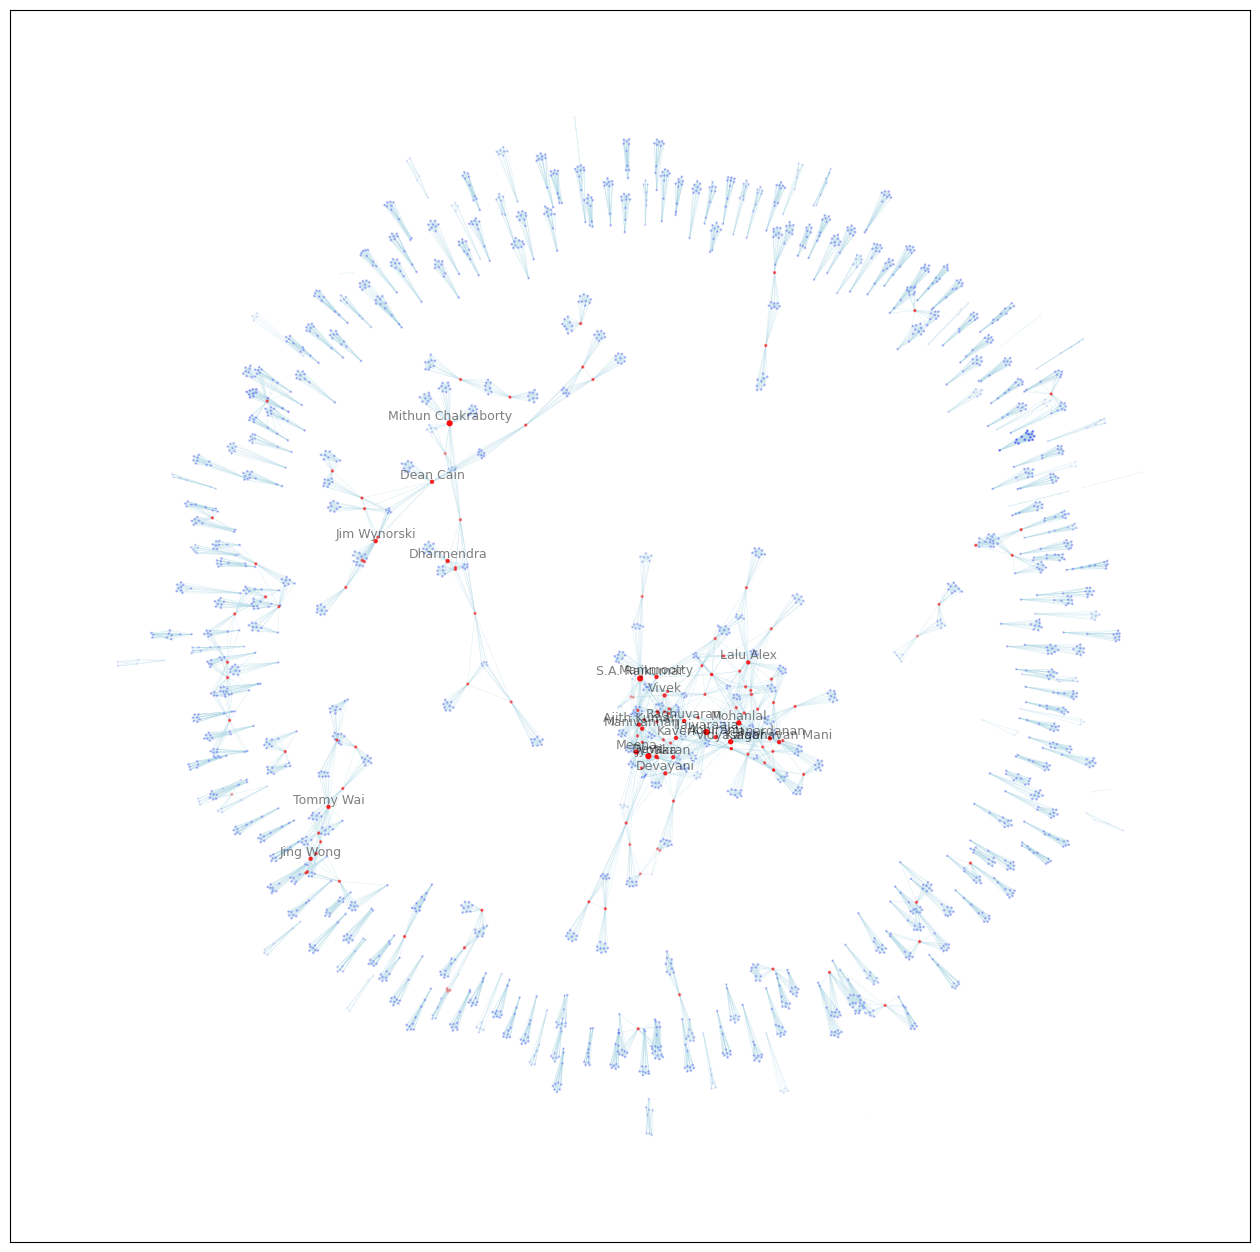

In [14]:
# Display the graph
size = (16,16)
params = compute_params(G)
fig = draw_graph(G, node_positions, size, params)
save_figure(fig, filename)

In [15]:
# Compute clustered graph
clusters = compute_clustering_coefficient(G)
G_clustered = generate_clustered_graph(G, clusters, 'plasma')

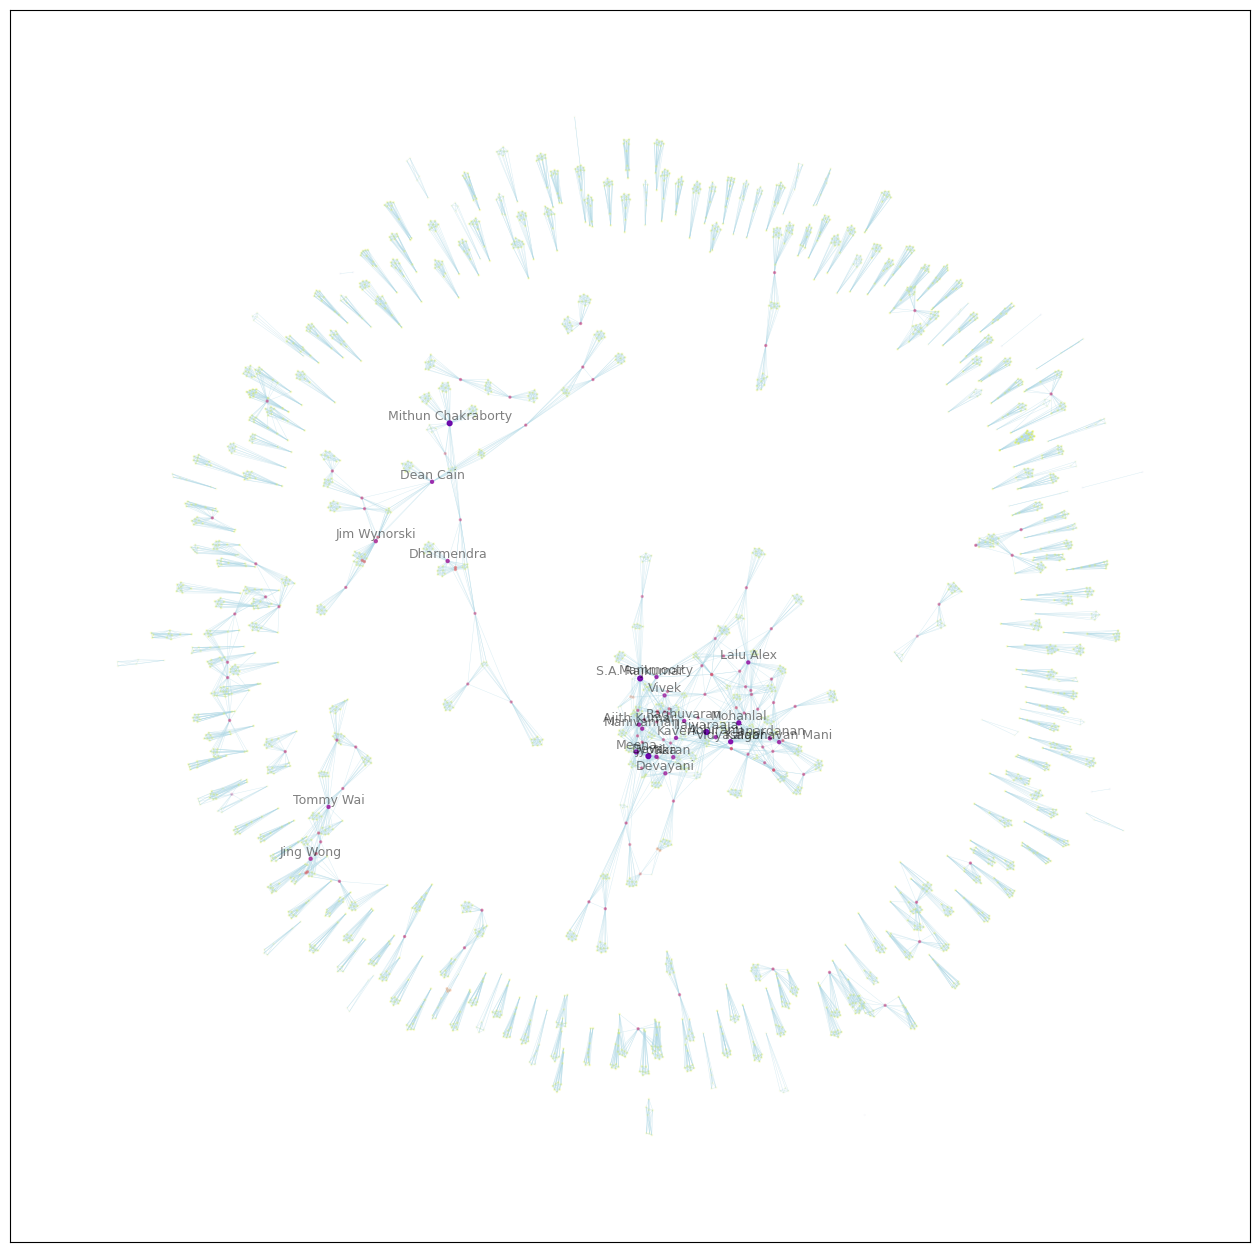

In [16]:
# Display clustered graph
size = (16,16)
params = compute_params(G_clustered)
fig = draw_graph(G_clustered, node_positions, size, params)
save_cluster_figure(fig, filename)

In [17]:
# Load a pickled graph and node positions
filename = 'test'

loaded_G = unpickle_graph(filename)
loaded_node_positions = unpickle_positions(filename)